In [ ]:
from typing import TypedDict, List, Annotated
import operator
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, BaseMessage, AIMessage
from langgraph.graph import StateGraph, END, START
from langgraph.prebuilt import ToolNode

# Reuse your existing Translator class
from translation import Translator 

# 1. Define State
class RefinementState(TypedDict):
    source_text: str
    source_lang: str
    target_lang: str
    initial_translation: str
    editor_feedback: str
    terminology_context: str  # To store the specific terms found by the tool
    final_output: str
    # Messages for the internal terminology agent loop
    messages: Annotated[List[BaseMessage], operator.add]

# 2. Setup
translator_instance = Translator()
terminology_tool = Translator.terminology_lookup
tools = [terminology_tool]

# specialized LLM for the terminology finder step
llm = ChatOpenAI(model="gpt-5-mini", temperature=0)
llm_with_tools = llm.bind_tools(tools)

# 3. Define Nodes

def initial_translation_node(state: RefinementState):
    """Step 1: Get the baseline translation using Translator.translate"""
    print(f"--- [Node 1] Initial Translation ({state['source_lang']} -> {state['target_lang']}) ---")
    result = translator_instance.translate(
        source_text=state["source_text"],
        source_lang=state["source_lang"],
        target_lang=state["target_lang"]
    )
    return {"initial_translation": result}

def editor_feedback_node(state: RefinementState):
    """Step 2: Get critique using Translator.editor_comments"""
    print("--- [Node 2] Editor Feedback (Evaluator) ---")
    feedback = translator_instance.editor_comments(
        source_text=state["source_text"],
        translated_text=state["initial_translation"],
        target_lang=state["target_lang"]
    )
    return {"editor_feedback": feedback}

def terminology_agent_node(state: RefinementState):
    """
    Step 3a: Terminology Agent. 
    Scans text and looks up terms using the tool. 
    It accumulates findings into the conversation history.
    """
    print("--- [Node 3a] Terminology Lookup Agent ---")
    
    # If this is the first entry, set the system prompt
    if not state["messages"]:
        prompt = f"""
        You are a Terminology Specialist. 
        1. Analyze the Source Text: "{state['source_text']}"
        2. Identify proper nouns, agencies (e.g. KWAP, EPF), and financial acronyms.
        3. Call the `terminology_lookup` tool for EACH identified term.
        4. Once you have looked up all terms, output a final summary list in this format:
           - Original: [Localized Term]
           
        Do not generate the final list until you have used the tool.
        """
        messages = [SystemMessage(content=prompt)]
    else:
        messages = state["messages"]
        
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

def should_continue_terminology(state: RefinementState):
    """Decides if the terminology agent needs to call a tool or is done."""
    last_message = state["messages"][-1]
    if last_message.tool_calls:
        return "tools"
    return "finalize_terms"

def finalize_terminology_node(state: RefinementState):
    """Step 3b: Extract the final list of terms found."""
    # The last message from the agent contains the summary of terms
    last_message = state["messages"][-1]
    return {"terminology_context": last_message.content}

def refinement_execution_node(state: RefinementState):
    """
    Step 4: The Optimizer.
    Calls Translator.refine_translation, passing in BOTH:
    1. The Editor's qualitative feedback
    2. The Terminology Agent's mandatory glossary
    """
    print("--- [Node 4] Executing Refinement (Optimizer) ---")
    
    # We combine feedback to pass into the single 'improvements' argument
    combined_feedback = (
        f"### Editor Suggestions:\n{state['editor_feedback']}\n\n"
        f"### Mandatory Terminology (Must Use):\n{state['terminology_context']}"
    )
    
    final_text = translator_instance.refine_translation(
        source_text=state["source_text"],
        initial_translated_text=state["initial_translation"],
        improvements=combined_feedback,
        source_lang=state["source_lang"],
        target_lang=state["target_lang"]
    )
    
    return {"final_output": final_text}

# 4. Build Graph
workflow = StateGraph(RefinementState)

workflow.add_node("translator", initial_translation_node)
workflow.add_node("editor", editor_feedback_node)
workflow.add_node("term_agent", terminology_agent_node)
workflow.add_node("tools", ToolNode(tools))
workflow.add_node("extract_terms", finalize_terminology_node)
workflow.add_node("refiner", refinement_execution_node)

# Define Flow
workflow.add_edge(START, "translator")
workflow.add_edge("translator", "editor")
workflow.add_edge("editor", "term_agent")

# Terminology Loop
workflow.add_conditional_edges(
    "term_agent",
    should_continue_terminology,
    {
        "tools": "tools",
        "finalize_terms": "extract_terms"
    }
)
workflow.add_edge("tools", "term_agent")

# Final Refinement
workflow.add_edge("extract_terms", "refiner")
workflow.add_edge("refiner", END)

app = workflow.compile()

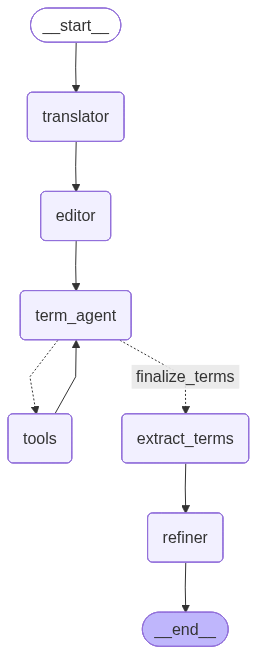

In [3]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print("Could not generate graph visualization. You might need 'grandalf' or similar.")

In [4]:
# Example Data: Using "Employees Provident Fund Board" to trigger the CSV lookup
sample_text = "The Employees Provident Fund Board (EPF) announced a higher PBT margin for the quarter."

inputs = {
    "source_text": sample_text,
    "source_lang": "English (Malaysia)",
    "target_lang": "Simplified Chinese (Malaysia)",
    "messages": [] # Initialize empty history
}

print(f"🚀 Starting Workflow for: '{sample_text}'\n")

# Stream the output to see the steps happening in real-time
for event in app.stream(inputs):
    pass # The print statements inside the nodes will show progress

print("\n" + "="*50)
# Retrieve final state
final_state = app.invoke(inputs)

print(f"📄 Source: {final_state['source_text']}")
print(f"📝 Direct Translation: {final_state['initial_translation']}")
print(f"🔎 Terminology Used: {final_state['terminology_context']}")
print(f"✅ FINAL REFINED OUTPUT: {final_state['final_output']}")
print("="*50)

🚀 Starting Workflow for: 'The Employees Provident Fund Board (EPF) announced a higher PBT margin for the quarter.'

--- [Node 1] Initial Translation (English (Malaysia) -> Simplified Chinese (Malaysia)) ---
--- [Node 2] Editor Feedback (Evaluator) ---
--- [Node 3a] Terminology Lookup Agent ---
--- [Node 3a] Terminology Lookup Agent ---
--- [Node 4] Executing Refinement (Optimizer) ---

--- [Node 1] Initial Translation (English (Malaysia) -> Simplified Chinese (Malaysia)) ---
--- [Node 2] Editor Feedback (Evaluator) ---
--- [Node 3a] Terminology Lookup Agent ---
--- [Node 3a] Terminology Lookup Agent ---
--- [Node 4] Executing Refinement (Optimizer) ---
📄 Source: The Employees Provident Fund Board (EPF) announced a higher PBT margin for the quarter.
📝 Direct Translation: 雇员公积金局（EPF）宣布本季度的税前利润率有所提高。
🔎 Terminology Used: Here are the official localized terms for the given terms:

1. **Employees Provident Fund Board**: 马来西亚雇员公积金局
2. **EPF**: No official localized term found.
3. **PBT**: 税前盈

In [ ]:
import operator
from typing import TypedDict, Annotated, List
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, BaseMessage
from langgraph.graph import StateGraph, END, START
from langgraph.prebuilt import ToolNode

# Import your services
from translation import Translator 
from evaluation_service import EvaluationAgent

# ====================================================
# 1. Define State (Added 'retry_count' and 'feedback')
# ====================================================
class IntegratedState(TypedDict):
    source_text: str
    source_lang: str
    target_lang: str
    initial_translation: str
    
    # Terminology found by the tool (The "Context" for Evaluation)
    terminology_context: str  
    
    # The current draft being evaluated
    current_draft: str
    
    # Evaluation Data
    eval_score: float
    eval_feedback: str
    is_passing: bool
    
    # Loop control
    retry_count: int
    messages: Annotated[List[BaseMessage], operator.add]

# ====================================================
# 2. Setup Tools & Models
# ====================================================
translator = Translator()
evaluator = EvaluationAgent(task_type="translation", threshold=0.85) # Checks Translation + Localization

# Terminology Tool setup
terminology_tool = Translator.terminology_lookup
tools = [terminology_tool]
llm_finder = ChatOpenAI(model="gpt-5-mini", temperature=0).bind_tools(tools)

# ====================================================
# 3. Define Nodes
# ====================================================

def initial_pass_node(state: IntegratedState):
    """Worker: Generate the first rough draft."""
    print(f"\n--- [Step 1] Initial Translation ---")
    res = translator.translate(state["source_text"], state["source_lang"], state["target_lang"])
    return {"initial_translation": res, "current_draft": res, "retry_count": 0}

def terminology_scan_node(state: IntegratedState):
    """Context: Agent scans for terms to lock in."""
    print(f"--- [Step 2] Scanning for Terminology ---")
    if not state["messages"]:
        prompt = f"""Identify financial acronyms/agencies in: "{state['source_text']}". 
        Use `terminology_lookup` for each. 
        Output ONLY a summary list: 'Original: [Localized]'."""
        messages = [SystemMessage(content=prompt)]
    else:
        messages = state["messages"]
    
    response = llm_finder.invoke(messages)
    return {"messages": [response]}

def extract_terms_node(state: IntegratedState):
    """Helper: Save the tool's findings to state."""
    return {"terminology_context": state["messages"][-1].content}

def refinement_node(state: IntegratedState):
    """Optimizer: Rewrite text using Terms + Feedback (if any)."""
    print(f"--- [Step 3] Refinement (Attempt {state['retry_count'] + 1}) ---")
    
    # Dynamic Prompt: Includes previous feedback if this is a retry
    feedback_context = ""
    if state["retry_count"] > 0:
        print(f"   ⚠️ Fixing based on feedback: {state['eval_feedback']}")
        feedback_context = f"\nPREVIOUS JUDGE FEEDBACK (MUST FIX): {state['eval_feedback']}"

    # Combine standard constraints with dynamic feedback
    improvements = (
        f"MANDATORY TERMINOLOGY:\n{state['terminology_context']}\n"
        f"{feedback_context}"
    )
    
    refined = translator.refine_translation(
        source_text=state["source_text"],
        initial_translated_text=state["initial_translation"], # Always refine from baseline
        improvements=improvements,
        source_lang=state["source_lang"],
        target_lang=state["target_lang"]
    )
    return {"current_draft": refined, "retry_count": state["retry_count"] + 1}

def evaluation_node(state: IntegratedState):
    """Judge: DeepEval checks the draft against Source + Terminology Map."""
    print(f"--- [Step 4] Evaluation (DeepEval) ---")
    
    # ⚡️ WIRING THE GAP: Pass terminology_context as the 'localization map'
    # This allows the metric to verify if the specific terms found were actually used.
    results = evaluator.evaluate(
        generated_text=state["current_draft"],
        source_context=state["source_text"],
        # We inject the findings from Step 2 into the metric's context
        # This satisfies the "predefined localization map" requirement in your prompt
        section_topic=f"Localization Map: {state['terminology_context']}" 
    )
    
    # Aggregate feedback from failing metrics
    feedback_list = []
    for name, m in results["metrics"].items():
        if not m["passed"]:
            feedback_list.append(f"[{name}] {m['feedback']}")
            
    return {
        "eval_score": results["average_score"],
        "is_passing": results["overall_pass"],
        "eval_feedback": " ".join(feedback_list)
    }

# ====================================================
# 4. Define Conditional Logic
# ====================================================
def check_quality(state: IntegratedState):
    """Decide: Loop back or Finish?"""
    if state["is_passing"]:
        return "pass"
    
    if state["retry_count"] >= 3:
        print("   🛑 Max retries reached. Returning best effort.")
        return "pass" # Force exit to prevent infinite loops
        
    return "retry"

def check_tools(state: IntegratedState):
    """Decide: Call tool or finish scanning?"""
    if state["messages"][-1].tool_calls:
        return "tools"
    return "done_scanning"

# ====================================================
# 5. Build Graph
# ====================================================
workflow = StateGraph(IntegratedState)

# Nodes
workflow.add_node("initial", initial_pass_node)
workflow.add_node("scanner", terminology_scan_node)
workflow.add_node("tools", ToolNode(tools))
workflow.add_node("extractor", extract_terms_node)
workflow.add_node("refiner", refinement_node)
workflow.add_node("judge", evaluation_node)

# Flow
workflow.add_edge(START, "initial")
workflow.add_edge("initial", "scanner")

# Tool Loop
workflow.add_conditional_edges("scanner", check_tools, {"tools": "tools", "done_scanning": "extractor"})
workflow.add_edge("tools", "scanner")

# Refine -> Judge Loop
workflow.add_edge("extractor", "refiner")
workflow.add_edge("refiner", "judge")
workflow.add_conditional_edges("judge", check_quality, {
    "pass": END, 
    "retry": "refiner" # <--- The Feedback Loop
})

app = workflow.compile()
print("✅ Self-Correcting Agent Compiled")

2025-11-24 22:50:34,034 [INFO] Initialized EvaluationAgent for task: translation


✅ Self-Correcting Agent Compiled


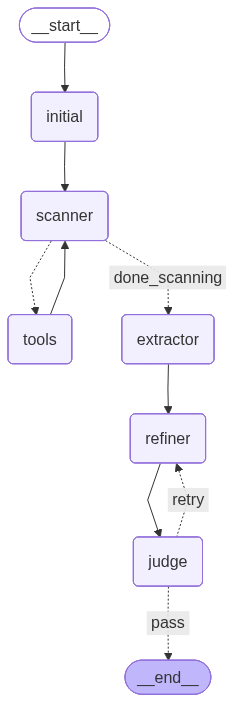

In [7]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print("Could not generate graph visualization. You might need 'grandalf' or similar.")

In [3]:
import nest_asyncio
nest_asyncio.apply()

sample_text = "Ni Hsin Group Bhd on Monday signed a heads of agreement (HOA) with the intention to acquire Hy-Fresh Group, one of Malaysia’s largest fully integrated halal-certified poultry businesses. In a filing with Bursa Malaysia, Ni Hsin said the HOA was signed with Datuk Seri Pua Tian Siong, who is the ultimate controlling shareholder and beneficial owner of Hy-Fresh Group. The agreement will allow both parties to negotiate exclusively within 90 days, or longer if required, to finalise a definitive agreement, subject to due diligence, valuation, and regulatory approvals. “The purchase consideration for the proposed acquisitions will be satisfied through a combination of cash and the issuance of new Ni Hsin shares at an indicative price of 12 sen each, with the final value and payment structure to be determined after due diligence and further negotiations,” it said.  Hy-Fresh Group’s operations cover feed milling, breeder and broiler farms, hatcheries, layer farms, processing plants, cold storage and distribution across Malaysia and Singapore. (The Edge)"

inputs = {
    "source_text": sample_text,
    "source_lang": "English",
    "target_lang": "Simplified Chinese (Malaysia)",
    "messages": []
}

print(f"🚀 Running Workflow for: '{sample_text}'")

# Using invoke instead of stream to keep the output clean, 
# but the print statements in the nodes will show progress.
final_state = app.invoke(inputs)

print("\n" + "="*30)
print(f"🏁 Final Result (Score: {final_state['eval_score']})")
print(f"Context Used: {final_state['terminology_context']}")
print(f"Final Text:   {final_state['current_draft']}")

🚀 Running Workflow for: 'Ni Hsin Group Bhd on Monday signed a heads of agreement (HOA) with the intention to acquire Hy-Fresh Group, one of Malaysia’s largest fully integrated halal-certified poultry businesses. In a filing with Bursa Malaysia, Ni Hsin said the HOA was signed with Datuk Seri Pua Tian Siong, who is the ultimate controlling shareholder and beneficial owner of Hy-Fresh Group. The agreement will allow both parties to negotiate exclusively within 90 days, or longer if required, to finalise a definitive agreement, subject to due diligence, valuation, and regulatory approvals. “The purchase consideration for the proposed acquisitions will be satisfied through a combination of cash and the issuance of new Ni Hsin shares at an indicative price of 12 sen each, with the final value and payment structure to be determined after due diligence and further negotiations,” it said.  Hy-Fresh Group’s operations cover feed milling, breeder and broiler farms, hatcheries, layer farms, proce

c:\Users\gooyt\Desktop\ai-news-agent\.venv\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

c:\Users\gooyt\Desktop\ai-news-agent\.venv\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

c:\Users\gooyt\Desktop\ai-news-agent\.venv\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

c:\Users\gooyt\Desktop\ai-news-agent\.venv\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

c:\Users\gooyt\Desktop\ai-news-agent\.venv\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

--- [Step 4] Evaluation (DeepEval) ---


c:\Users\gooyt\Desktop\ai-news-agent\.venv\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

c:\Users\gooyt\Desktop\ai-news-agent\.venv\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

c:\Users\gooyt\Desktop\ai-news-agent\.venv\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

2025-11-24 22:55:32,370 [INFO] [TRANSLATION] Factual Fidelity: 1.000 | PASS
2025-11-24 22:55:32,370 [INFO] [TRANSLATION] Content Importance & Relevance: 1.000 | PASS
2025-11-24 22:55:32,371 [INFO] [TRANSLATION] Professional Tone & Grammar: 1.000 | PASS
2025-11-24 22:55:32,371 [INFO] [TRANSLATION] Executive Writing Quality: 0.900 | PASS
2025-11-24 22:55:32,372 [INFO] [TRANSLATION] Translation Tone Adherence: 0.900 | PASS
2025-11-24 22:55:32,372 [INFO] [TRANSLATION] Translation Financial Entity Localization: 0.900 | PASS



🏁 Final Result (Score: 0.95)
Context Used: Here are the official localized terms for the given terms:

- **Bhd**: 国库控股有限公司 (This is the localized term for "Bhd" in Chinese, which stands for "Berhad" in Malay, indicating a public limited company in Malaysia.)
- **HOA**: No official localized term found.
- **Bursa Malaysia**: No official localized term found.
Final Text:   尼欣集团国库控股有限公司于周一签署了一份意向协议（HOA），旨在收购Hy-Fresh集团，该集团是马来西亚最大的全方位整合的清真认证禽类企业之一。在向马来西亚证券交易所的文件中，尼欣表示该HOA是与Hy-Fresh集团的最终控股股东和受益所有人拿督斯里普阿天雄签署的。该协议将允许双方在90天内独家谈判，或在必要时延长，以最终确定一份正式协议，前提是进行尽职调查、估值和监管批准。“拟议收购的购买对价将通过现金和以每股12仙的指示价格发行新尼欣股份的组合来满足，最终的价值和支付结构将在尽职调查和进一步谈判后确定，”该公司表示。Hy-Fresh集团的业务涵盖饲料加工、种鸡和肉鸡养殖场、孵化场、蛋鸡养殖场、加工厂、冷藏和在马来西亚及新加坡的分销。（The Edge）


In [ ]:
import os
from company_validator import BursaCompanyValidator

# 1. Initialize
print("--- Diagnostic Check ---")
validator = BursaCompanyValidator()

# 2. Check if INFOM is in the map
target_key = "infom"
if target_key in validator.company_map:
    data = validator.company_map[target_key]
    print(f"✅ SUCCESS: Found 'infom' in map!")
    print(f"   Mapped to: {data.get('company_long')}")
    print(f"   Source config: company_short='{data.get('company_short')}'")
else:
    print(f"❌ FAIL: 'infom' is NOT in the map.")
    print("   Please check: Did you save the jsonl file? Did you restart the kernel?")

# 3. Test the exact scraped item
item = {'name': 'Infomina Bhd', 'ticker': 'KL:INFOM'}
result = validator.validate_and_enrich(item)

if result:
    print(f"\n✅ VALIDATION PASSED: {result.get('ticker')} - {result.get('company_official_name')}")
else:
    print(f"\n❌ VALIDATION FAILED for input: {item}")

--- Diagnostic Check ---
--- [Validator] Loaded 1013 Bursa companies. ---
❌ FAIL: 'infom' is NOT in the map.
   Please check: Did you save the jsonl file? Did you restart the kernel?

✅ VALIDATION PASSED: 0265 - INFOMINA BERHAD
